In [143]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import matplotlib.pyplot as plt
from itertools import product

In [81]:
import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

Compare smoke impact estimates created in wildfire.ipynb with AQI estimates created in aqi.ipynb

Load and plot smoke_impact_fires_650miles.csv that was created by wildfire.ipynb

In [85]:
# Read in smoke impact estimates from csv
smoke_estimate = pd.read_csv('smoke_impact_fires_650miles.csv')

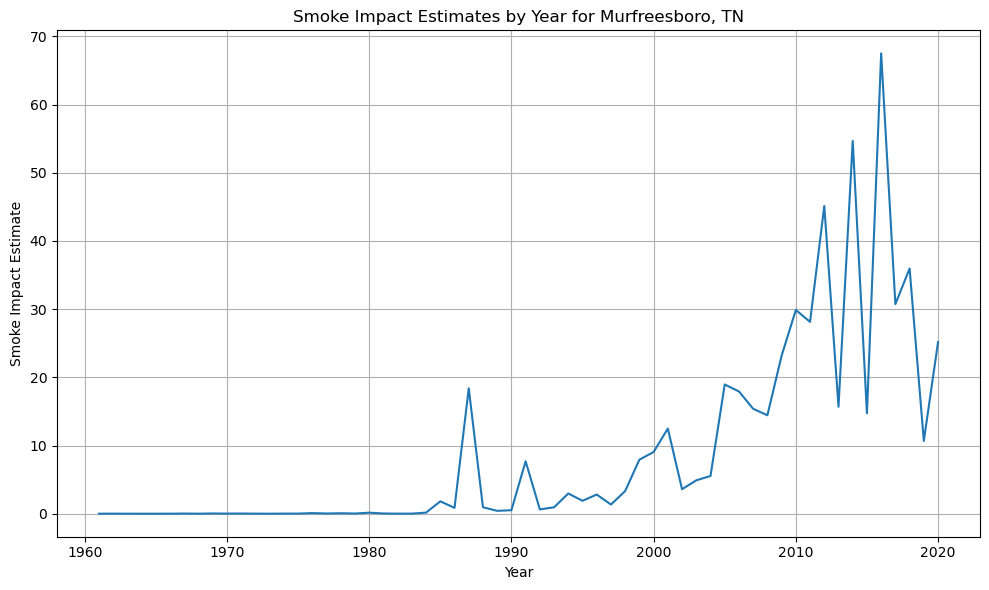

In [90]:
# Plot smoke impact estimates
plt.figure(figsize=(10, 6))
plt.plot(smoke_estimate['year'], smoke_estimate['smoke_impact_estimate'])
plt.title('Smoke Impact Estimates by Year for Murfreesboro, TN')
plt.xlabel('Year')
plt.ylabel('Smoke Impact Estimate')
plt.grid(True)
plt.tight_layout()


Load and plot AQI Estimates from 'year_mean.csv' file that was generated by aqi.ipynb

In [110]:
# Read in aqi estimates from csv
aqi_estimate = pd.read_csv('year_mean.csv')

In [121]:
# Format date column
aqi_estimate['year'] = aqi_estimate['year'].astype('int64')

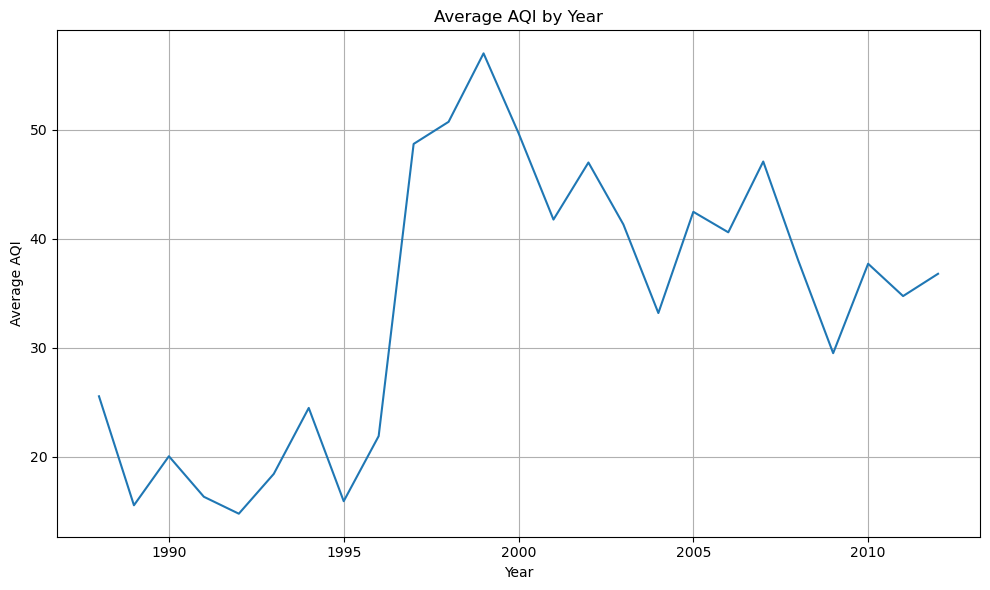

In [122]:
# Plot aqi estimates
plt.figure(figsize=(10, 6))
plt.plot(aqi_estimate['year'], aqi_estimate['max_aqi'])
plt.title('Average AQI by Year')
plt.xlabel('Year')
plt.ylabel('Average AQI')
plt.grid(True)
plt.tight_layout()


Compare smoke impact estimates and AQI

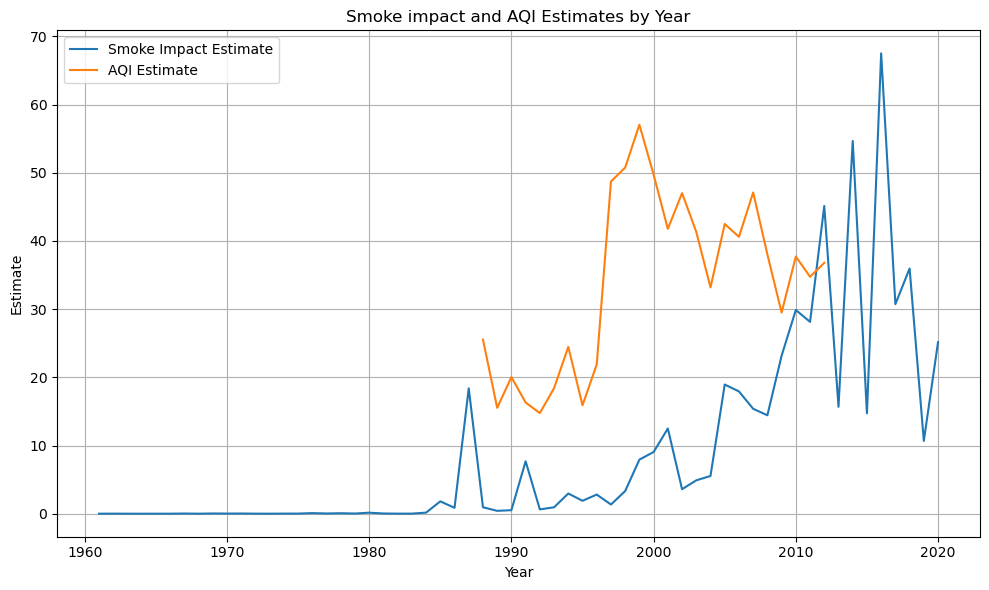

In [93]:
# Plot smoke impact estimates and aqi estimates
plt.figure(figsize=(10, 6))
plt.plot(smoke_estimate['year'], smoke_estimate['smoke_impact_estimate'], label = 'Smoke Impact Estimate')
plt.plot(aqi_estimate, label = 'AQI Estimate')
plt.title('Smoke impact and AQI Estimates by Year')
plt.xlabel('Year')
plt.ylabel('Estimate')
plt.legend()
plt.grid(True)
plt.tight_layout()


Compare with correlation

In [136]:
# Merge the DataFrames on 'year'
merged_df = pd.merge(aqi_estimate, smoke_estimate, on='year', how='inner')
merged_df_filtered =merged_df[['year', 'max_aqi', 'smoke_impact_estimate']]

# Calculate correlation matrix
correlation_matrix = merged_df_filtered.corr()

# Display the correlation matrix
print(correlation_matrix)

                           year   max_aqi  smoke_impact_estimate
year                   1.000000  0.551771               0.831766
max_aqi                0.551771  1.000000               0.279829
smoke_impact_estimate  0.831766  0.279829               1.000000


The trends are slightly opposite for some years when graphing the aqi and smoke impact estimates. When looking at the correlation we can see that the value is 0.2798 so there is a weak positive correlation between the AQI estimate and the Smoke Impact Estimate. However, there is not AQI data for many of the years so if we expanded this, it could be different. Additonally, these are just estimates that were calculated in very different ways. For more details on the smoke estimate calculation refer to the wildfire.ipynb and for AQI estimate refer to the aqi.ipynb. The AQI values that I had available were SO2, NO2, and O2. Oxygen is not really impacted by wildfire smoke, but sulfer levels can be if the fire is buring vegetation with a lot sulfur. NO2 however, is a part of what makes up wildfire smoke, so these levels should be dirrectly correlated with wildfire smoke levels. If I had a monitor that had particulate values like PM2.5, my AQI estimate would be a better detection of wildfire smoke.

Create predictive model for smoke impact estimates for fires within 650 miles using smoke_impact_fires_650miles.csv that was created by wildfire.ipynb

Predictive model using ARIMA

Best ARIMA parameters: (3, 1, 0) with RMSE: 22.586047420187132


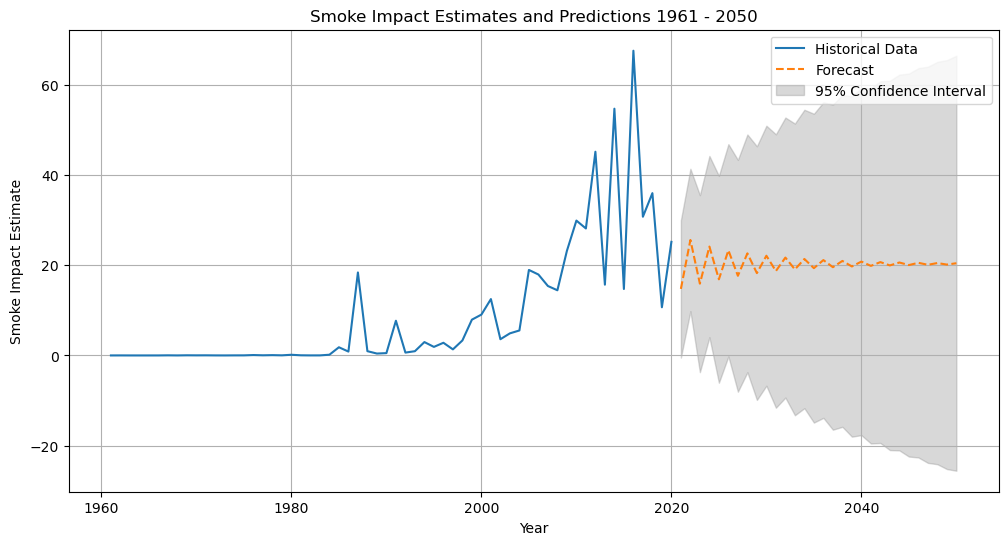

In [83]:
# Load the CSV data for smoke impact estimates
df = pd.read_csv('smoke_impact_fires_650miles.csv')

# Set year as index and get timeseries data
df.set_index('year', inplace=True)
ts = df['smoke_impact_estimate']

# Split 80/20 for training and testing sets
train_size = int(len(ts) * 0.8)
train, test = ts[:train_size], ts[train_size:]

# Range for paramter testing for p, d,  q
p_values = range(0, 4)
d_values = range(0, 2)
q_values = range(0, 4)

# Vars for grid search
best_values = None
best_rmse = float('inf')

# Grid search for p, d, q
for p, d, q in product(p_values, d_values, q_values):
    try:
        model = ARIMA(train, order=(p, d, q))
        model_fit = model.fit()
        predictions = model_fit.forecast(steps=len(test))

        # Find root mean squared error
        rmse = sqrt(mean_squared_error(test, predictions))

        # Update to keep params with lowest RMSE
        if rmse < best_rmse:
            best_rmse = rmse
            best_values = (p, d, q)
    except:
        continue

print(f'Best ARIMA parameters: {best_values} with RMSE: {best_rmse}')

# Fit the model with best param on the full dataset
model = ARIMA(ts, order=best_values)
model_fit = model.fit()

# Predict till 2050 with 95% confidence interval
forecast_result = model_fit.get_forecast(steps=30)
preds = forecast_result.predicted_mean
conf_int = forecast_result.conf_int(alpha=0.05)


# Create a DataFrame for the predictions
pred_df = pd.DataFrame({'year': range(2021, 2051), 'predicted_smoke_impact': preds.values, 'lower_bound': conf_int['lower smoke_impact_estimate'],'upper_bound': conf_int['upper smoke_impact_estimate']})

# Plot the historical data, test data, and the forecast
plt.figure(figsize=(12, 6))
plt.plot(df.index, ts, label='Historical Data')
plt.plot(pred_df['year'], pred_df['predicted_smoke_impact'], label='Forecast', linestyle='--')
plt.fill_between(pred_df['year'], pred_df['lower_bound'], pred_df['upper_bound'], color='gray', alpha=0.3, label='95% Confidence Interval')
#plt.plot(aqi_estimate, label = 'AQI Estimate')
plt.xlabel('Year')
plt.ylabel('Smoke Impact Estimate')
plt.title('Smoke Impact Estimates and Predictions 1961 - 2050')
plt.legend()
plt.grid(True)
plt.show()


Visualizations

For the following visual analysis, I will use the distance_df.csv file that was created in wildfire.ipynb which contains all fires and their year, size, and distance from Murfreesboro, TN within 1800 miles.

In [138]:
distance_df = pd.read_csv('distance_df.csv')

In [141]:
distance_df.drop(columns=['Unnamed: 0'], inplace=True)

In [142]:
distance_df

,year,size,distance
0,1961,13511.581889,1614.765324
1,1961,9691.440667,1636.838400
2,1961,9205.967944,1736.430765
3,1961,6606.235548,1681.151426
4,1961,6431.525486,1697.432922
...,...,...,...
84456,2020,60.879054,1758.510909
84457,2020,14.545208,1754.509357
84458,2020,7.050837,1760.078462
84459,2020,9.342668,1760.134603


Produce a histogram showing the number of fires occurring every 50 mile distance from your assigned city for all fires ranging up to 1800 miles away from your assigned city. Your histogram should indicate the distance cut-off for your modeling work as specified in Step 1.

In [147]:
# Seperate fires that are within 650 cut off and those between 650 adn 1800
df_650 = distance_df[distance_df['distance'] <= 650]
df_1800 = distance_df[distance_df['distance'] > 650]

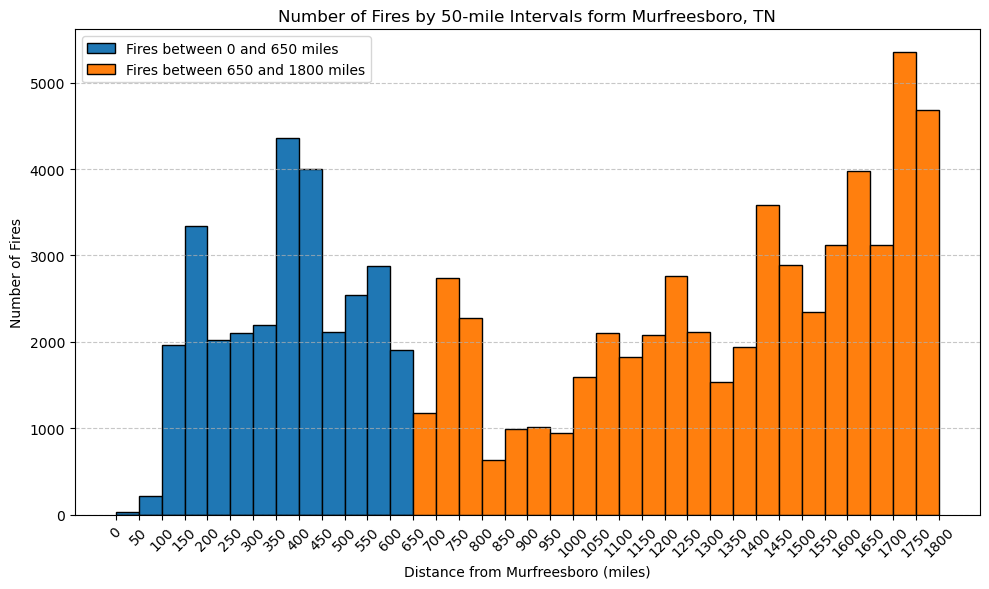

In [149]:
# Create bins for every 50 miles between 0 and 1800
bins = np.arange(0, 1850, 50)

# Plot the histogram for the number of fires by distance every 50 miles
plt.figure(figsize=(10, 6))
plt.hist(df_650['distance'], bins=bins, edgecolor='black', label = 'Fires between 0 and 650 miles')
plt.hist(df_1800['distance'], bins=bins, edgecolor='black', label = 'Fires between 650 and 1800 miles')
plt.title("Number of Fires by 50-mile Intervals form Murfreesboro, TN")
plt.xlabel("Distance from Murfreesboro (miles)")
plt.ylabel("Number of Fires")
plt.xticks(bins, rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

Produce a time series graph of total acres burned per year for the fires occurring in the specified distance from your city.

In [155]:
df_650_total_acres = df_650.groupby('year')['size'].sum()

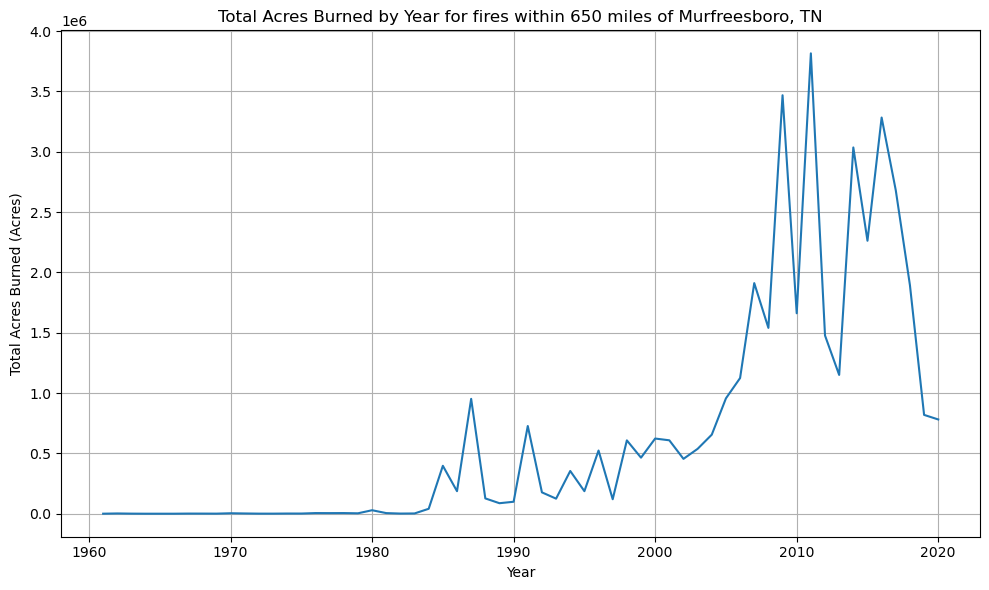

In [157]:
# Plot total acres burned per year
plt.figure(figsize=(10, 6))
plt.plot(df_650_total_acres)
plt.title('Total Acres Burned by Year for fires within 650 miles of Murfreesboro, TN')
plt.xlabel('Year')
plt.ylabel('Total Acres Burned (Acres)')
plt.grid(True)
plt.tight_layout()


Produce a time series graph containing your fire smoke estimates for your city and the AQI estimates for your city.

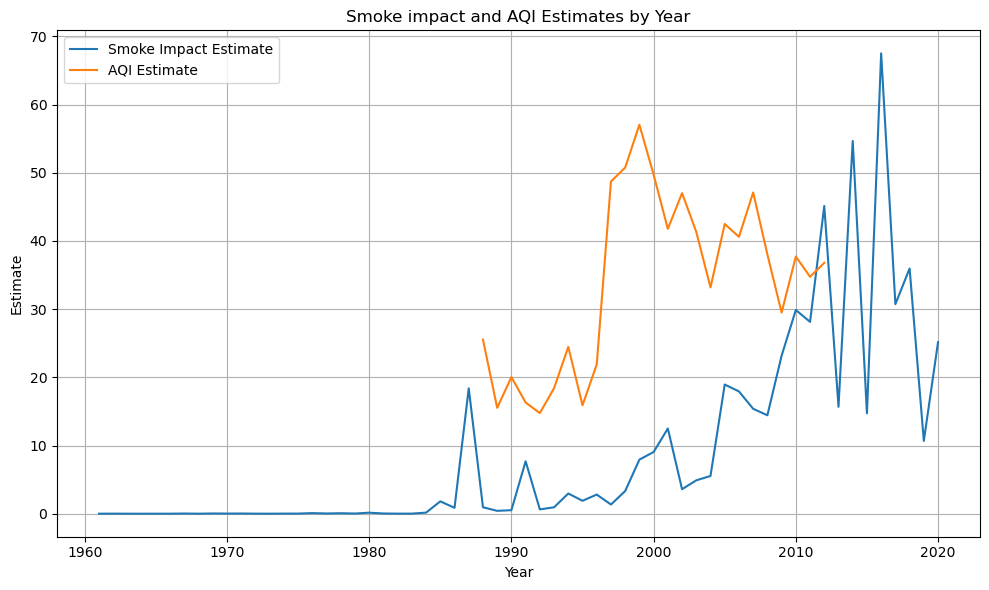

In [161]:
# Plot smoke impact estimates and aqi estimates
plt.figure(figsize=(10, 6))
plt.plot(smoke_estimate['year'], smoke_estimate['smoke_impact_estimate'], label = 'Smoke Impact Estimate')
plt.plot(aqi_estimate['year'],aqi_estimate['max_aqi'], label = 'AQI Estimate')
plt.title('Smoke impact and AQI Estimates by Year')
plt.xlabel('Year')
plt.ylabel('Estimate')
plt.legend()
plt.grid(True)
plt.tight_layout()
